資料來源：https://www.openml.org/search?type=data&status=active&id=43390 

# Importing Required Libraries

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score ,f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

In [249]:
!git clone https://github.com/judyschen/Portfolio.git

fatal: destination path 'Portfolio' already exists and is not an empty directory.


# Loading Dataset

In [250]:
# Load the dataset
churn_df = pd.read_csv("Portfolio/Churn-for-Bank-Customers.csv")

In [251]:
# Display the first few rows of the dataset to understand its structure
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Data Overview and Data Cleaning

In [252]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


下面的乘述要再對照一下結果看有沒有服和

一共有10000筆客戶的資料，以及14個變數，根據OpenML資料，各變數的說明如下：
1. RowNumber: Likely serving as a unique identifier for each entry, it holds no direct analytical significance.

2. CustomerId: Used for tracking and distinguishing individual customers within the dataset.

3. Surname: Surname of a customer has no impact on their decision to leave the bank

4. CreditScore: Numerical assessment of an individual's creditworthiness based on their financial history, a customer with a higher credit score is less likely to leave the bank.

5. Geography: Provides geographical information about customers, facilitating analysis based on regional or national factors.

6. Gender: Categorizes customers into male or female, enabling gender-based analysis where applicable.

7. Age: Represents the customer's age in years, useful for analyzing age-related trends and behaviors.

8. Tenure: Tenure refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

9. Balance: Balance is also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances. 

10. NumOfProducts: May encompass various offerings such as savings accounts, loans, and credit cards. This column is also relevant.

11. HasCrCard: Binary variable indicating possession of a credit card (1 for yes, 0 for no), since people with a credit card are less likely to leave the bank.

12. IsActiveMember: Binary variable indicating whether the customer is an active member (1) or not (0) within the bank.  Active customers are less likely to leave the bank.

13. EstimatedSalary: Approximation of the customer's income level, relevant for analyzing churn behavior, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

14. Exited: Indicates whether a customer has churned (1) or not (0) from the bank, serving as the target variable for prediction using other features.

In [253]:
churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [254]:
churn_df.duplicated().sum()

0

本資料並沒有缺失值或是重複值

對分類列進行描述性統計分析:

In [255]:
churn_df.describe(include="object").T

,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457


Surnamer基數高，與預測客戶流失無關; 地理和性別列的基數較低，似乎與預測客戶流失相關。

RowNumber 和 CustomerId 欄位以及 Surname欄位與預測客戶流失無關，可以刪除。

In [256]:
churn_df.drop(columns=["RowNumber","CustomerId","Surname"],inplace=True)

# Exploratory Data Analysis

(1) 流失人數 Exited

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/210637085.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=churn_df, x='Exited', palette="tab10", dodge=False, linewidth=2.5)


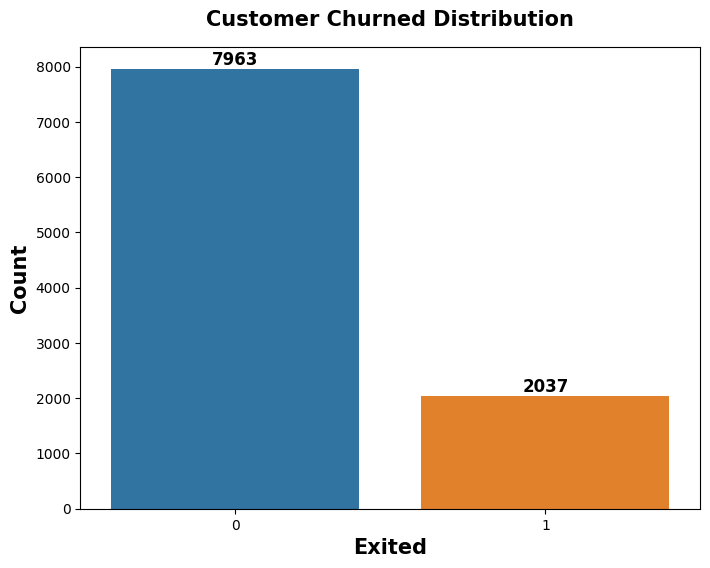

In [257]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=churn_df, x='Exited', palette="tab10", dodge=False, linewidth=2.5)
for container in ax.containers:
    ax.bar_label(container, fontweight="black", size=12)
plt.title("Customer Churned Distribution", fontweight="bold", size=15, pad=15)
plt.xlabel("Exited", fontweight="bold", size=15)
plt.ylabel("Count", fontweight="bold", size=15)

plt.show()

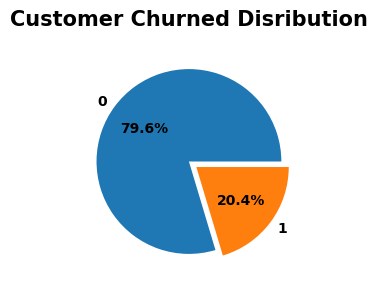

In [258]:
count = churn_df["Exited"].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("tab10"),
        textprops={"fontweight":"black"},explode=[0,0.1])
plt.title("Customer Churned Disribution",fontweight="black",size=15,pad=15)
plt.show()

推斷數據是不平衡的

(2) 性別 Gender

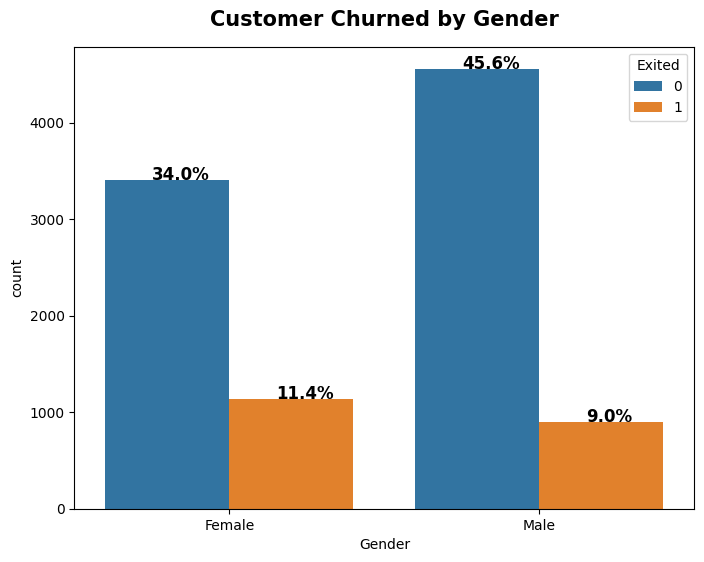

In [259]:
def countplot(column):
    plt.figure(figsize=(8,6))
    ax = sns.countplot(x=column, data=churn_df, hue="Exited", palette="tab10")
    for value in ax.patches:
        height = value.get_height()
        if height != 0:  # Skip annotation if count is 0
            percentage = "{:.1f}%".format(100 * height / len(churn_df[column]))
            x = value.get_x() + value.get_width() / 2 - 0.05
            y = value.get_y() + height
            ax.annotate(percentage, (x, y), fontweight="black", size=12)

    plt.title(f"Customer Churned by {column}", fontweight="black", size=15, pad=15)
    plt.show()

countplot("Gender")

男性的總數超過一半，但女性的流失率較高

(3) 地理位置

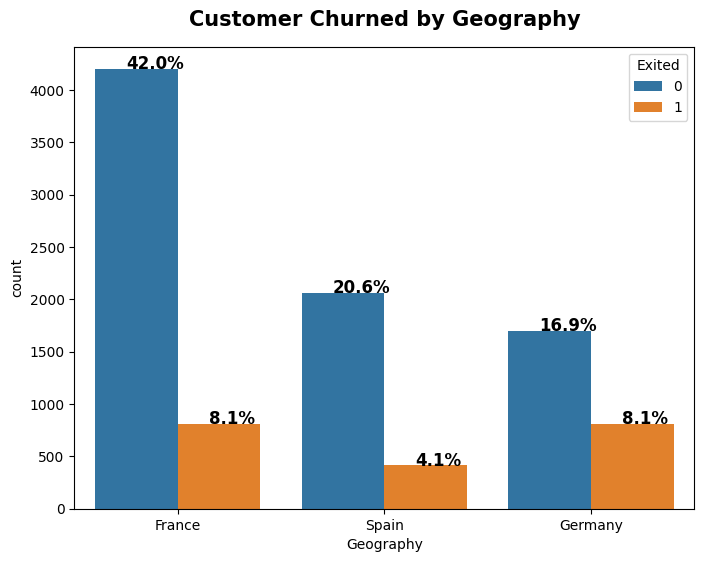

In [260]:
countplot("Geography")

超過一半的客戶來自法國，其次是德國和西班牙。
儘管法國和德國之間的客戶總數存在巨大差異，但法國和德國客戶的流失率是相同的。
西班牙和德國的客戶數量幾乎相等，但德國的客戶流失率幾乎是西班牙的兩倍。

(4) 是否持有信用卡HasCrCard


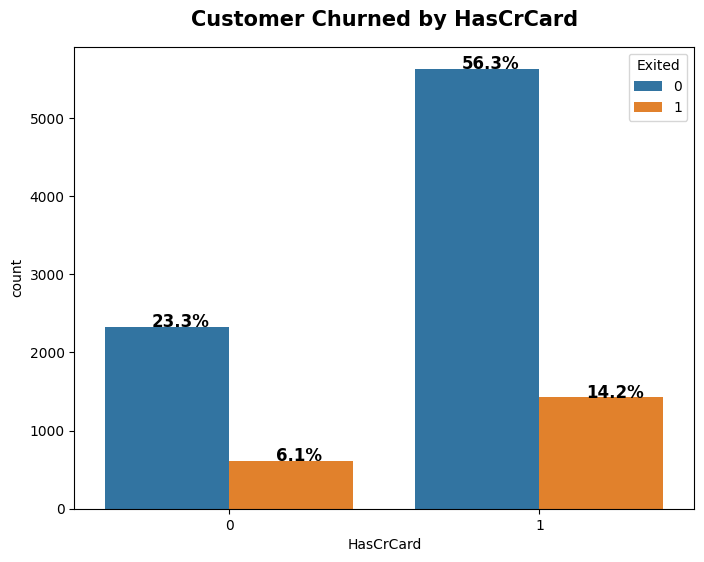

In [261]:
countplot("HasCrCard")

超過70%的客戶擁有信用卡。
這兩個類別的流失機率值幾乎為 1:4

(5)持有的金融商品數量 NumOfProducts

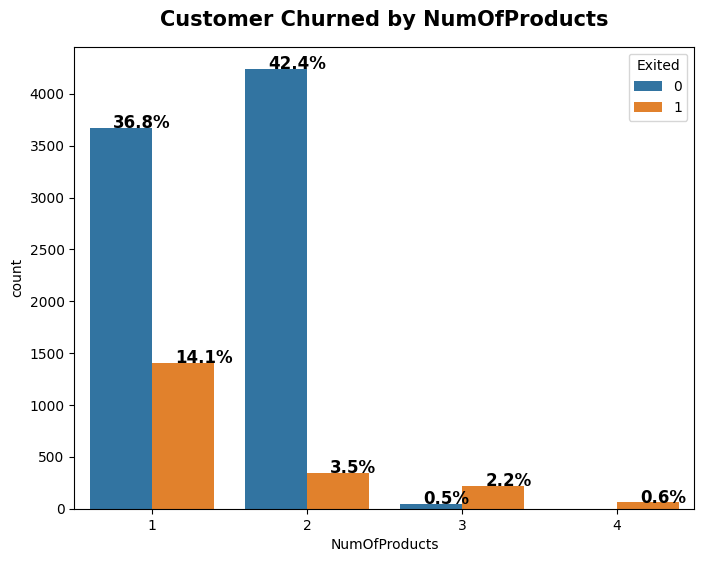

In [262]:
countplot("NumOfProducts")

大多數客戶擁有 1 或 2 種銀行產品。
很少有客戶擁有超過 2 種銀行產品。
擁有 1 種產品的客戶流失率非常高。

Tips:
我們可以透過將超過 2 個產品的客戶分組在一起來進行特徵工程，以減少類別不平衡。
因為階級不平衡會導致模型的偏差和對少數階級的扭曲。

In [263]:
conditions = [(churn_df["NumOfProducts"]==1), (churn_df["NumOfProducts"]==2), (churn_df["NumOfProducts"]>2)]
values =     ["One product","Two Products","More Than 2 Products"]

churn_df["Total_Products"] = np.select(conditions,values)
churn_df.drop(columns="NumOfProducts", inplace=True)

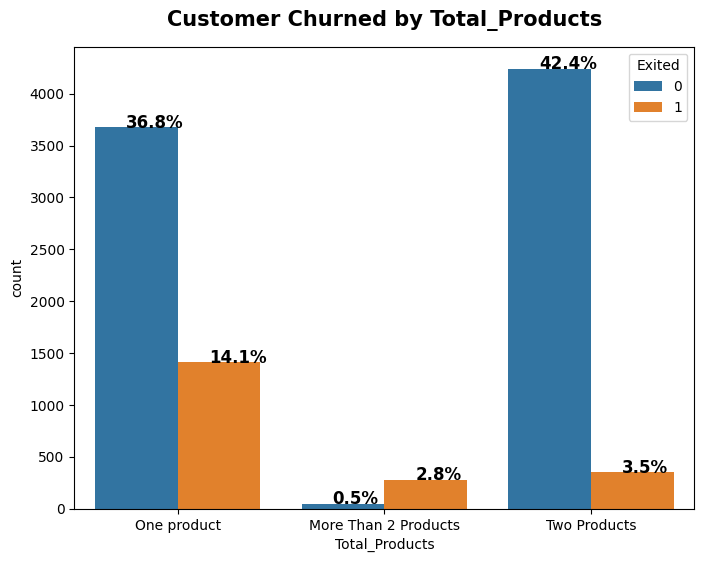

In [264]:
countplot("Total_Products")

(6) 是否是活躍用戶 IsActiveMember

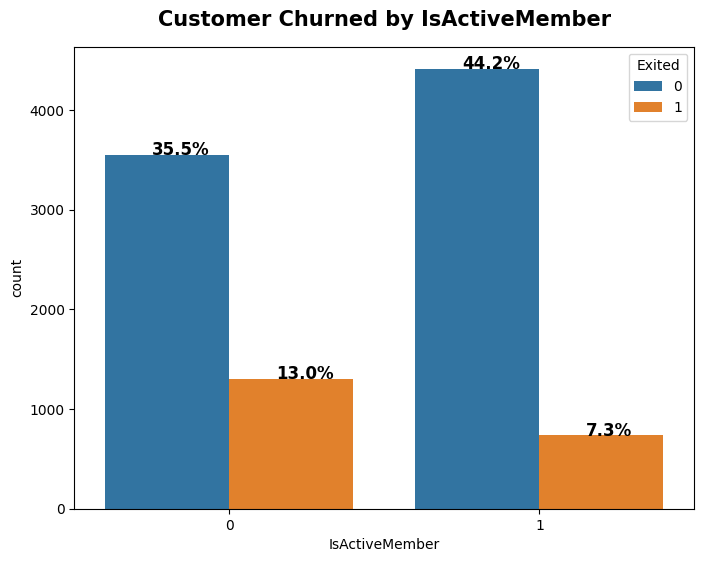

In [265]:
countplot("IsActiveMember")

活躍或不活躍的客戶數量大致相等。
但不活躍客戶的流失率幾乎是活躍客戶的兩倍。
因此，不活躍的客戶更有可能停用其銀行帳戶。

(7)使用期 Tenure

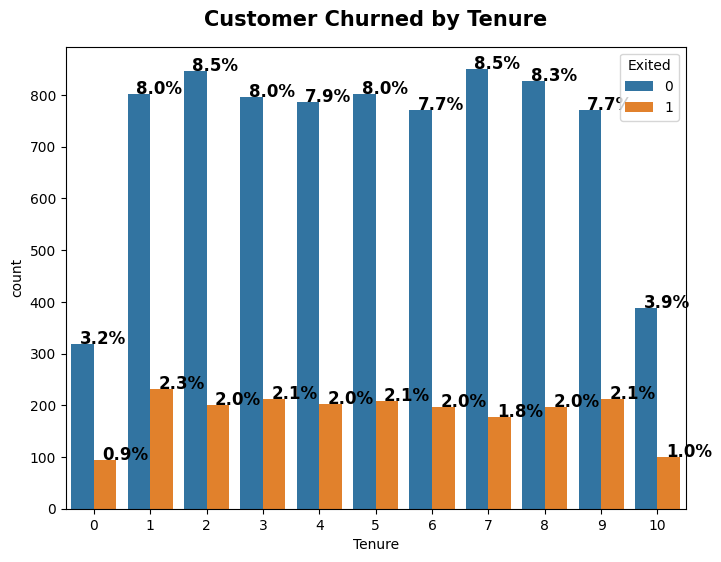

In [266]:
countplot("Tenure")

不管多久的使用期，客戶流失狀態的分佈幾乎相似

(7) 信用分數 CreditScore

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/2045592423.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y=column, data=churn_df, palette="tab10")


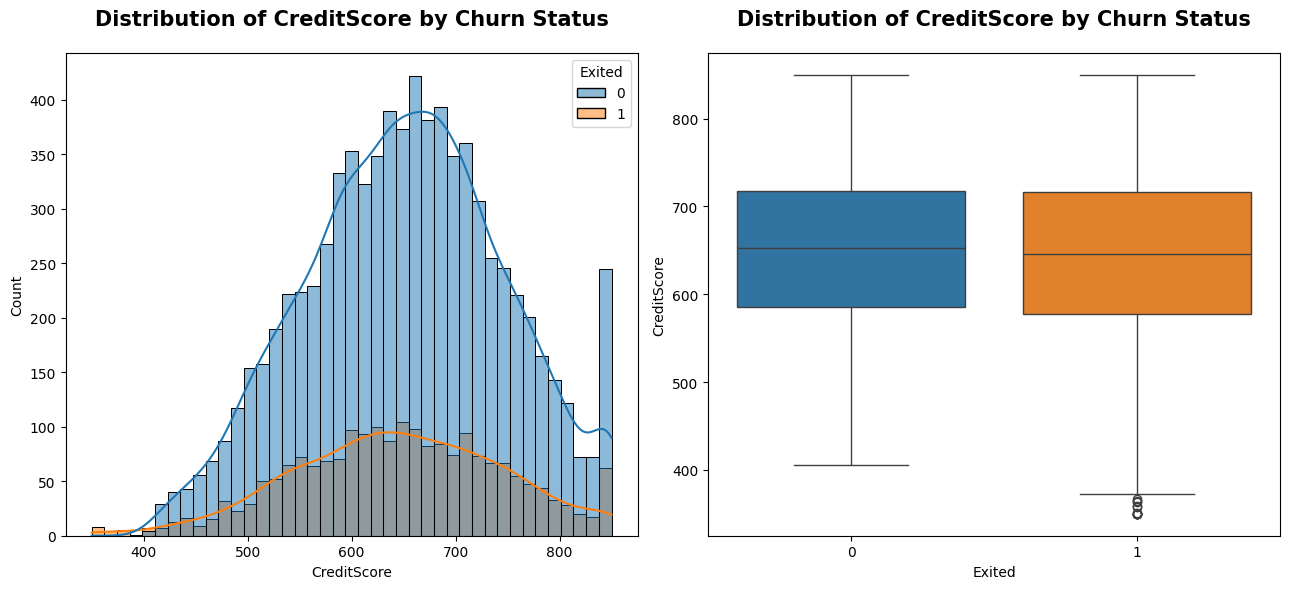

In [267]:
def continous_plot(column):
    plt.figure(figsize=(13, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(x=column, hue="Exited", data=churn_df, kde=True, palette="tab10")
    plt.title(f"Distribution of {column} by Churn Status", fontweight="black", pad=20, size=15)

    plt.subplot(1, 2, 2)
    sns.boxplot(x="Exited", y=column, data=churn_df, palette="tab10")
    plt.title(f"Distribution of {column} by Churn Status", fontweight="black", pad=20, size=15)
    plt.tight_layout()
    plt.show()

continous_plot("CreditScore")


流失客戶和未流失客戶的信用評分皆為常態分佈，中位數大致相等。

(8) 年齡 Age

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/2045592423.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y=column, data=churn_df, palette="tab10")


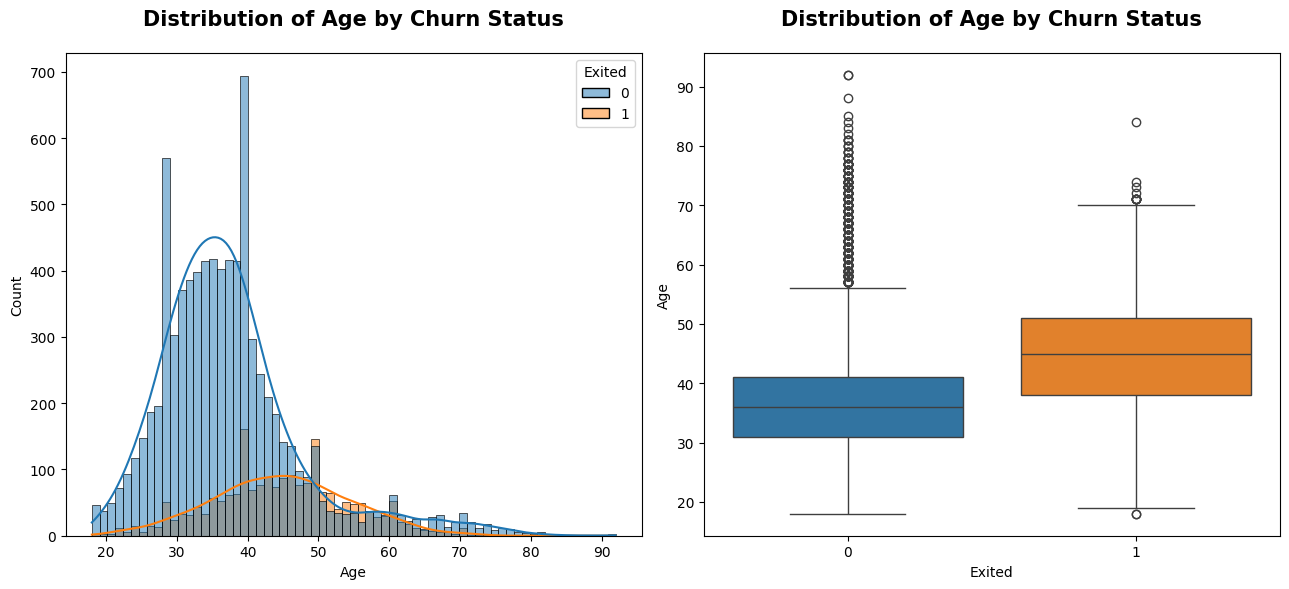

In [268]:
continous_plot("Age")

由於異常值的存在，分佈呈現右偏態，這可能導致模型過度擬合。 為了克服這種右偏分佈，我們可以使用對數轉換常態分佈。

(9)餘額Balance

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/2045592423.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y=column, data=churn_df, palette="tab10")


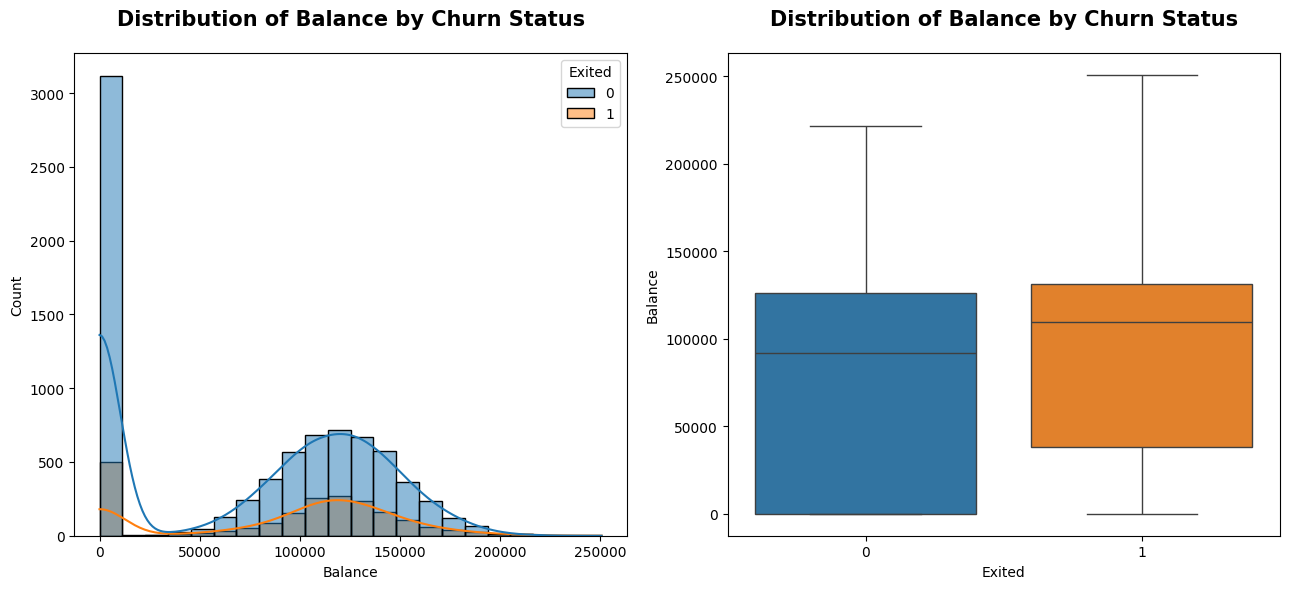

In [269]:
continous_plot("Balance")

超過 3000 名客戶的帳戶餘額為零。
餘額為零的客戶更有可能停用其帳戶。
排除零值，我們可以觀察到常態分佈。 因此不必使用任何其他技術。

Tips:我們可以將帳戶餘額等於0和餘額大於0的客戶分別分組來進行特徵工程。

In [270]:
conditions = [(churn_df["Balance"]==0), (churn_df["Balance"]>0)]
values = ["Zero Balance","More Than zero Balance"]

churn_df["Account_Balance"] = np.select(conditions, values)
churn_df.drop(columns="Balance",inplace=True)

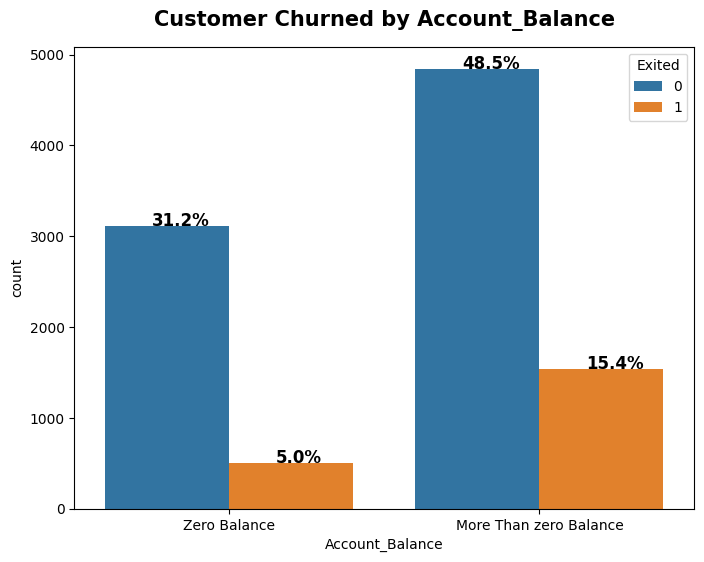

In [271]:
countplot("Account_Balance")

(11) 預期薪資 EstimatedSalary

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/2045592423.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Exited", y=column, data=churn_df, palette="tab10")


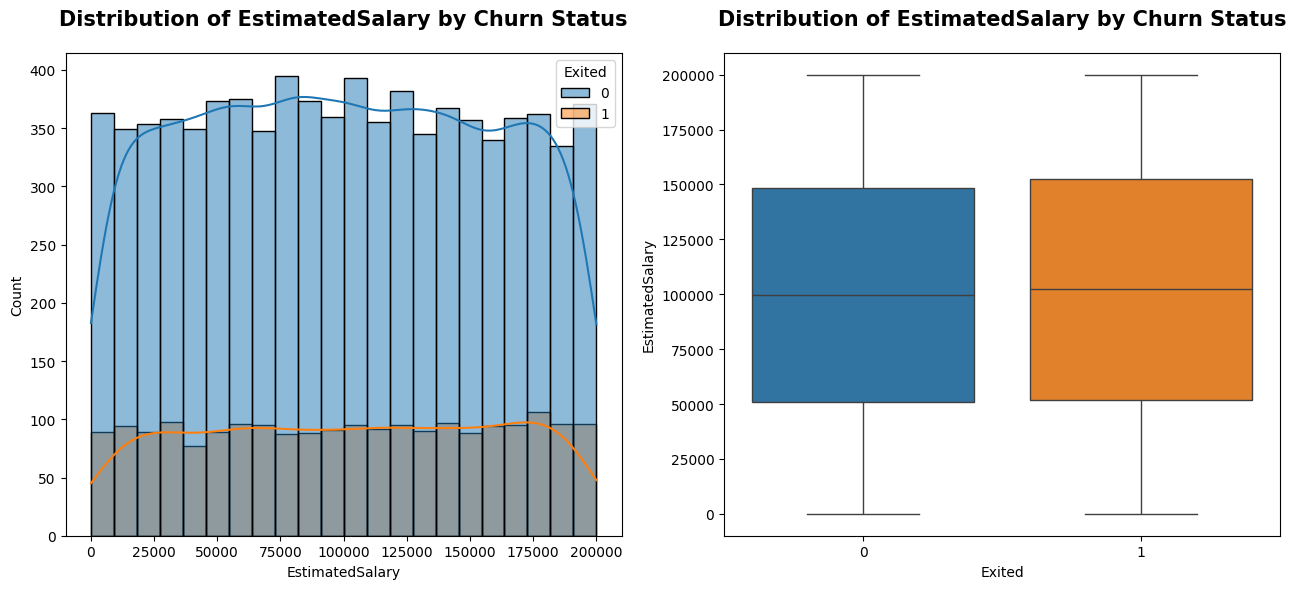

In [272]:
continous_plot("EstimatedSalary")

兩個流失類別的 EstimatedSalary 中位數大致相同。兩個流失類別的分佈相似

In [273]:
churn_df.describe(include="object").T

,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
Total_Products,10000,3,One product,5084
Account_Balance,10000,2,More Than zero Balance,6383


In [274]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
 9   Total_Products   10000 non-null  object 
 10  Account_Balance  10000 non-null  object 
dtypes: float64(1), int64(6), object(4)
memory usage: 859.5+ KB


Geography, Gender, Total_Products, Account_Balance四個變數為object，而以下需要做資料處理

# 資料預處理Data Preprocessing

In [275]:
cat_cols = ["Geography","Gender","Total_Products","Account_Balance"]

In [276]:
# Create dummy variables for the categorical columns, dropping the baseline
churn = pd.get_dummies(churn_df, columns=cat_cols, drop_first=True)


In [277]:
churn.head()

,CreditScore,Age,Tenure,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Total_Products_One product,Total_Products_Two Products,Account_Balance_Zero Balance
0,619,42,2,1,1,101348.88,1,False,False,False,True,False,True
1,608,41,1,0,1,112542.58,0,False,True,False,True,False,False
2,502,42,8,1,0,113931.57,1,False,False,False,False,False,False
3,699,39,1,0,0,93826.63,0,False,False,False,False,True,True
4,850,43,2,1,1,79084.10,0,False,True,False,True,False,False


In [278]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CreditScore                   10000 non-null  int64  
 1   Age                           10000 non-null  int64  
 2   Tenure                        10000 non-null  int64  
 3   HasCrCard                     10000 non-null  int64  
 4   IsActiveMember                10000 non-null  int64  
 5   EstimatedSalary               10000 non-null  float64
 6   Exited                        10000 non-null  int64  
 7   Geography_Germany             10000 non-null  bool   
 8   Geography_Spain               10000 non-null  bool   
 9   Gender_Male                   10000 non-null  bool   
 10  Total_Products_One product    10000 non-null  bool   
 11  Total_Products_Two Products   10000 non-null  bool   
 12  Account_Balance_Zero Balance  10000 non-null  bool   
dtypes:

 # 檢查連續特徵的偏態

In [279]:
cols = ["CreditScore","Age","EstimatedSalary"]
churn[cols].skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
CreditScore,-0.071607
Age,1.011320
EstimatedSalary,0.002085


年齡特徵是高度右偏的，這表示存在正異常值。
偏度會對某些機器學習演算法（例如決策樹和線性模型）的表現產生負面影響。
為了克服右偏分佈，我們可以使用對數常態變換來實現常態分佈。

4. Performing Log Transformation on Age Column.

In [280]:
old_age = churn["Age"]     ##Storing the previous Age values to compare these values with the transformed values.
churn["Age"] = np.log(churn["Age"])

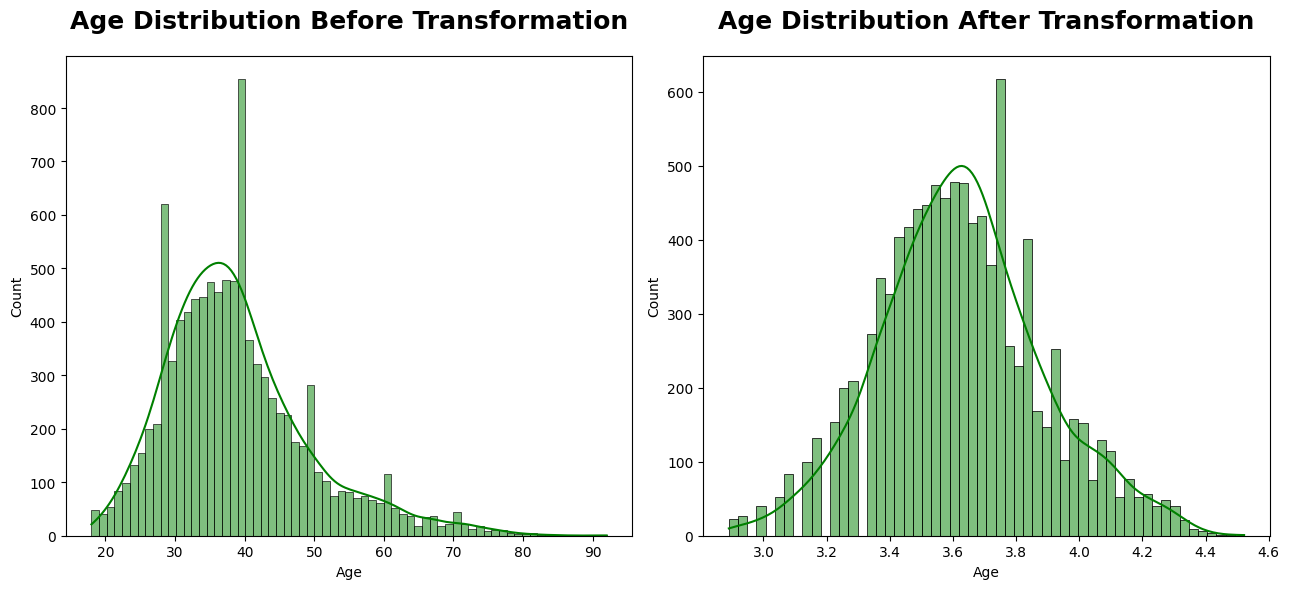

In [281]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
sns.histplot(old_age, color="green", kde=True)
plt.title("Age Distribution Before Transformation", fontweight="bold", size=18, pad=20)

plt.subplot(1,2,2)
sns.histplot(churn["Age"], color="green", kde=True)
plt.title("Age Distribution After Transformation", fontweight="bold", size=18, pad=20)
plt.tight_layout()
plt.show()

對數常態變換後，年齡已達到常態分佈。
這將有助於建立更準確的模型。

In [294]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CreditScore                   10000 non-null  int64  
 1   Age                           10000 non-null  float64
 2   Tenure                        10000 non-null  int64  
 3   HasCrCard                     10000 non-null  int64  
 4   IsActiveMember                10000 non-null  int64  
 5   EstimatedSalary               10000 non-null  float64
 6   Exited                        10000 non-null  int64  
 7   Geography_Germany             10000 non-null  bool   
 8   Geography_Spain               10000 non-null  bool   
 9   Gender_Male                   10000 non-null  bool   
 10  Total_Products_One product    10000 non-null  bool   
 11  Total_Products_Two Products   10000 non-null  bool   
 12  Account_Balance_Zero Balance  10000 non-null  bool   
dtypes:

# Splitting Data For Model Training & Testing.

In [282]:
X = churn.drop(columns=["Exited"])
y = churn["Exited"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Model Creation using DecisionTree

In [288]:
dtree = DecisionTreeClassifier()

param_grid = {"max_depth":[3,4,5,6,7,8,9,10],
              "min_samples_split":[2,3,4,5,6,7,8],
              "min_samples_leaf":[1,2,3,4,5,6,7,8],
              "criterion":["gini","entropy"],
              "splitter":["best","random"],
              "max_features":["auto",None],
              "random_state":[0,42]}

grid_search = GridSearchCV(dtree, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train,y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
17920 fits failed out of a total of 35840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9497 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/pyth

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'random_state': [0, 42],
                         'splitter': ['best', 'random']})

In [289]:
best_parameters = grid_search.best_params_

print("Best Parameters for DecisionTree Model is:")
best_parameters

Best Parameters for DecisionTree Model is:


{'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'random_state': 42,
 'splitter': 'random'}

In [292]:
dtree = grid_search.best_estimator_

In [293]:
y_train_pred = dtree.predict(X_train)
y_test_pred = dtree.predict(X_test)

print("Accuracy Score of Model on Training Data is ",round(accuracy_score(y_train,y_train_pred)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is ",round(accuracy_score(y_test,y_test_pred)*100,2),"%")

Accuracy Score of Model on Training Data is  86.74 %
Accuracy Score of Model on Testing Data  is  86.5 %


In [ ]:
print("F1 Score of the Model is ",f1_score(y_test,y_test_pred,average="micro"))
print("Recall Score of the Model is ",recall_score(y_test,y_test_pred,average="micro"))
print("Precision Score of the Model is ",precision_score(y_test,y_test_pred,average="micro"))

F1 Score of the Model is  0.865
Recall Score of the Model is  0.865
Precision Score of the Model is  0.865


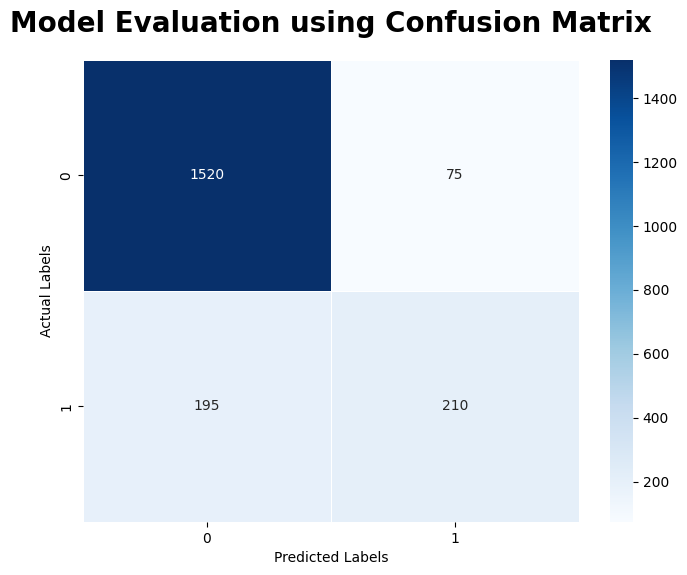

In [ ]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Blues")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

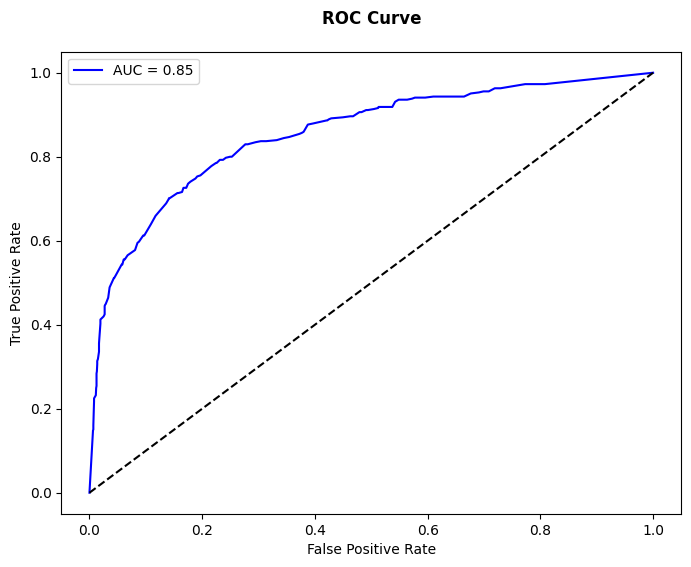

In [ ]:
y_pred_proba = dtree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

AUC（曲線下面積）值為 0.85，表示模型具有很強的判別力。
這表明該模型具有很強的區分正例和負例的能力，表明其在做出準確預測方面的有效性。
此模型有相對較高的機率將隨機選擇的正實例排名高於隨機選擇的負實例。

In [ ]:
imp_df = pd.DataFrame({"Feature Name":X_train.columns,
                       "Importance":dtree.feature_importances_})

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/264108578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature Name", data=features, palette="viridis")


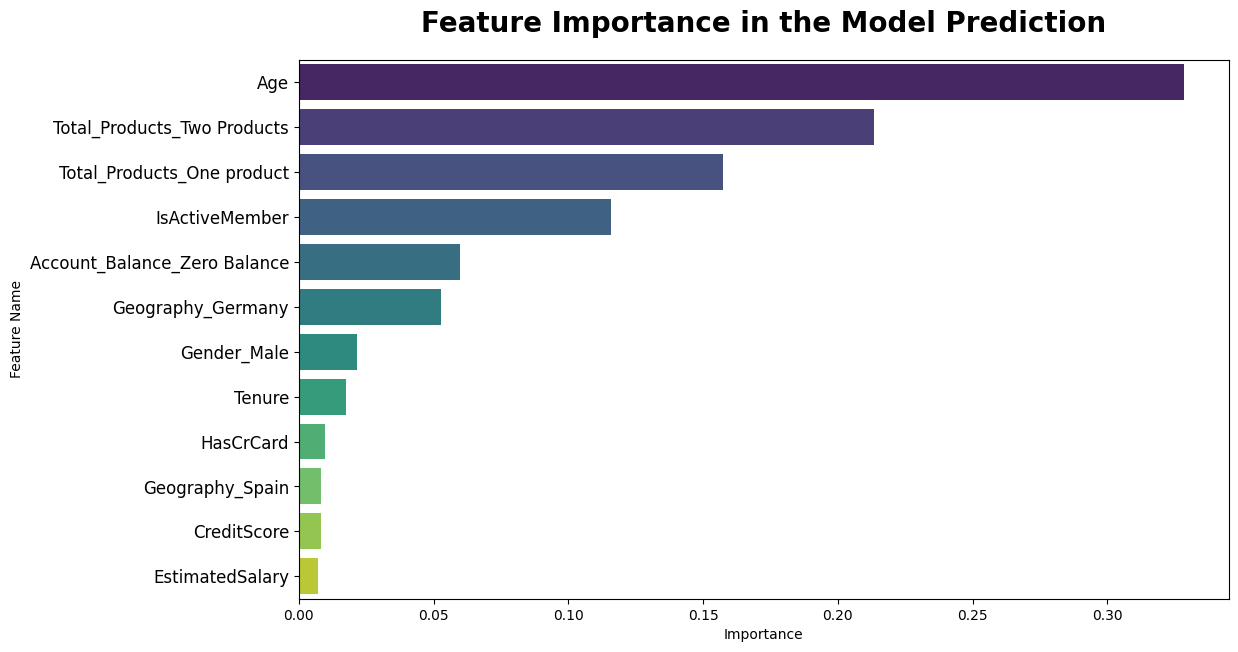

In [ ]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="viridis")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

顯著影響客戶銀行停用的關鍵因素是：年齡、Total_Products、IsActiveMember、餘額、地理位置德國和性別。

對停用客戶銀行設施的最小影響是：使用期限、HasCrCard、信用評分、和預估薪資

# Model Creation using Random Forest

下面跑13分鐘

In [ ]:
rfc = RandomForestClassifier()
param_grid = {"max_depth":[3,4,5,6,7,8],
              "min_samples_split":[3,4,5,6,7,8],
              "min_samples_leaf":[3,4,5,6,7,8],
              "n_estimators": [50,70,90,100],
              "criterion":["gini","entropy"],
            "random_state":[0,42]}

grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'min_samples_split': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [50, 70, 90, 100],
                         'random_state': [0, 42]})

In [ ]:
best_parameters = grid_search.best_params_

print("Best Parameters for RandomForest Model is:")
best_parameters

Best Parameters for RandomForest Model is:


{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'n_estimators': 70,
 'random_state': 0}

In [ ]:
rfc = RandomForestClassifier(max_depth= 8, min_samples_leaf= 8, min_samples_split=3, n_estimators= 70,random_state=0)

rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=8, min_samples_split=3,
                       n_estimators=70, random_state=0)

In [ ]:
y_train_pred = rfc.predict(X_train)
y_test_pred  = rfc.predict(X_test)

print("Accuracy Score of Model on Training Data is ",round(accuracy_score(y_train,y_train_pred)*100,2),"%")
print("Accuracy Score of Model on Testing Data  is ",round(accuracy_score(y_test,y_test_pred)*100,2),"%")

Accuracy Score of Model on Training Data is  87.22 %
Accuracy Score of Model on Testing Data  is  86.6 %


In [ ]:
print("F1 Score of the Model is ",f1_score(y_test,y_test_pred,average="micro"))
print("Recall Score of the Model is ",recall_score(y_test,y_test_pred,average="micro"))
print("Precision Score of the Model is ",precision_score(y_test,y_test_pred,average="micro"))

F1 Score of the Model is  0.866
Recall Score of the Model is  0.866
Precision Score of the Model is  0.866


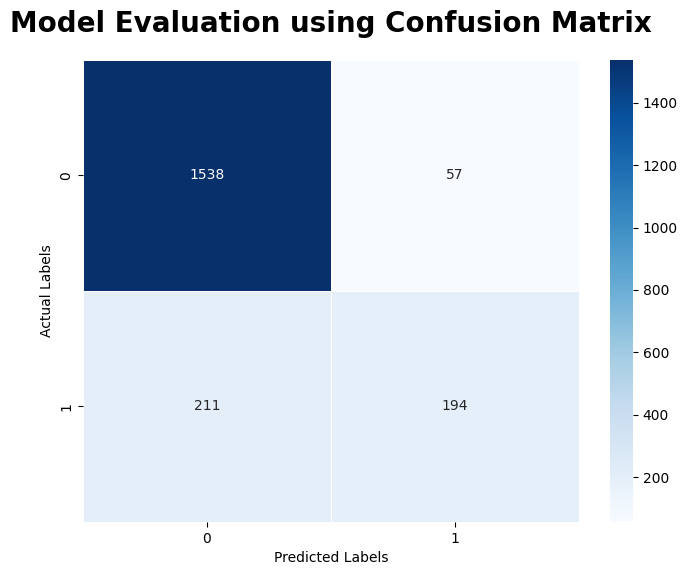

In [ ]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(8,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Blues")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

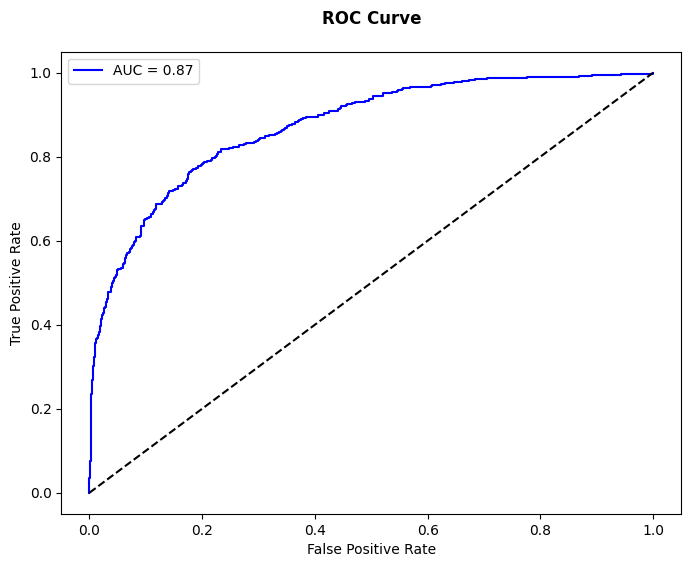

In [ ]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()

AUC（曲線下面積）值為 0.87，表示模型具有很強的判別力。
這表明該模型具有很強的區分正例和負例的能力，表明其在做出準確預測方面的有效性。
此模型有相對較高的機率將隨機選擇的正實例排名高於隨機選擇的負實例。

In [ ]:

imp_df = pd.DataFrame({"Feature Name":X_train.columns,
                       "Importance":rfc.feature_importances_})

/var/folders/7t/2s7tnw3j37l9tv8my4v83hzc0000gn/T/ipykernel_65122/264108578.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature Name", data=features, palette="viridis")


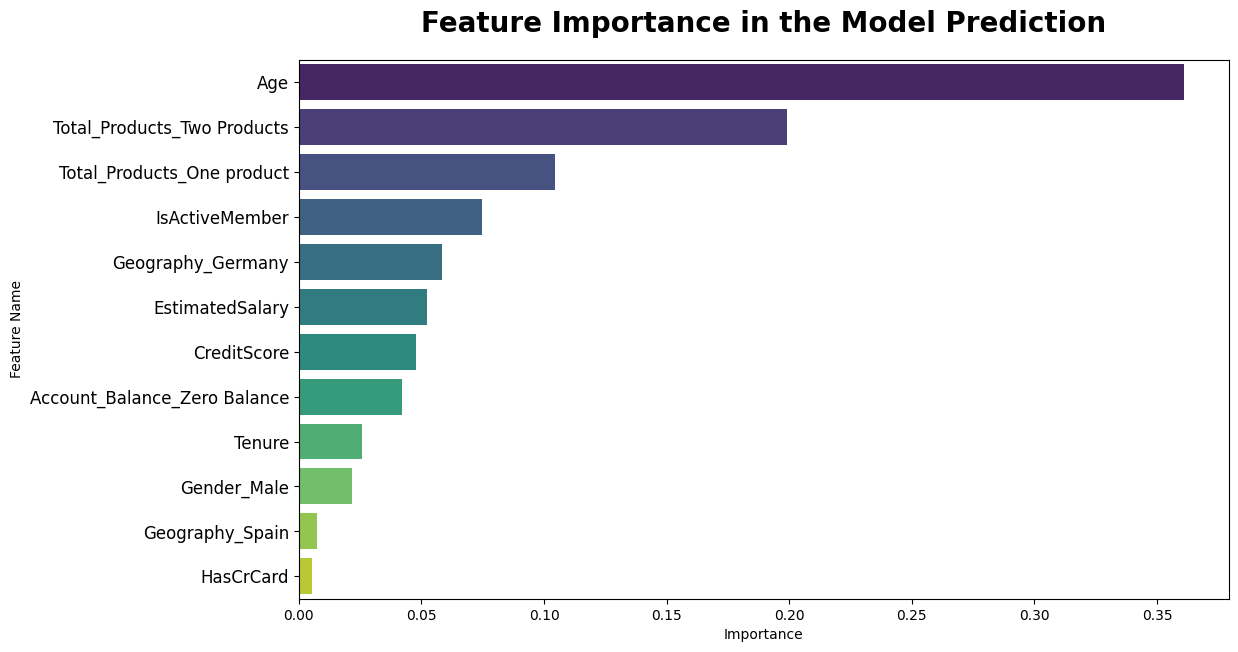

In [ ]:
features = imp_df.sort_values(by="Importance",ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(x="Importance", y="Feature Name", data=features, palette="viridis")
plt.title("Feature Importance in the Model Prediction", fontweight="black", size=20, pad=20)
plt.yticks(size=12)
plt.show()

## 結論：


1. 由於Random Forest的表現較Decision Tree良好，未來可以使用該模型並繼續優化

2. 顯著影響客戶銀行設施停用的關鍵因素是Age、 Total_Products、 IsActiveMember、Geography-German和Estimated Salary 。

3. 模型的準確度和 F1 Score 都相當高（約87%），這說明這個模型應該已經相當有效地捕捉到了客戶流失的主要特性，可以作為制定策略的很好的基礎。

4. AUC 值為 0.87，顯示模型具有相當好的區分能力。 這表明該模型能夠以相對較高的準確度區分正例和負例。
